In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from itertools import product
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

register_matplotlib_converters()

### Seasonal version of ARIMA are designed for short periods, for example period = 12 for monthly data with yearly season, period = 7 for daily data with weekly season season. I've tried to run period = 365 for the daily store/item data but my com ran out of RAM and blue screened.

### The data clearly shows a yearly season but from the ACF and PACF plots, there might be a weekly season also.

In [3]:
train_df = pd.read_csv("../data/train.csv")
train_df["date"] = pd.to_datetime(train_df["date"])
df1 = train_df[(train_df["store"] == 1) & (train_df["item"] == 1)][["date", "sales"]]
series1 = pd.Series(df1["sales"].values, df1["date"])
series1

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Length: 1826, dtype: int64

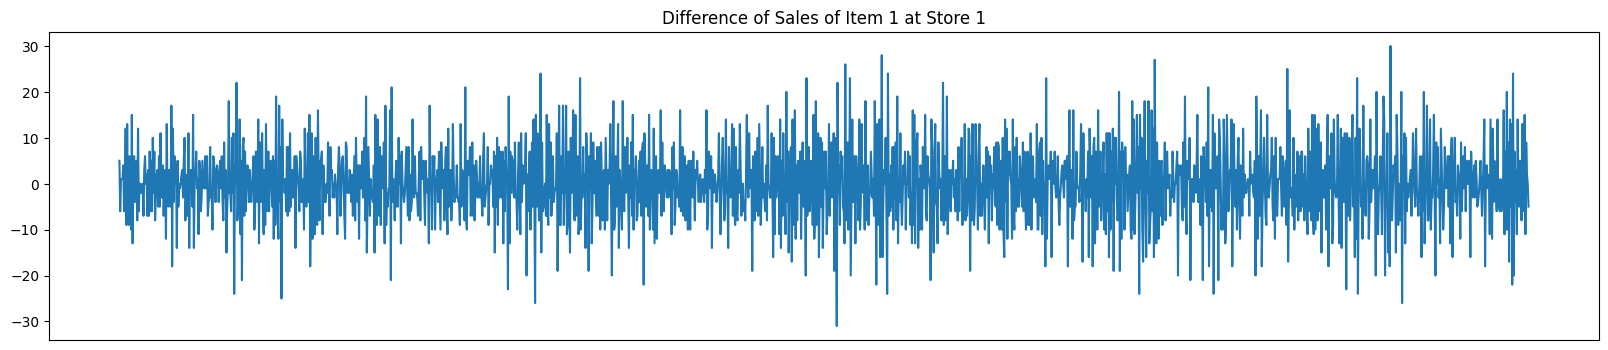

In [4]:
# 7 lag diffed and then 1 diffed
series2 = series1.diff(periods=7).diff().dropna()

plt.figure(figsize=(20,4))
plt.xticks(rotation=45)
x = np.arange(0, len(series2.index), 120)
plt.xticks(x, series2.index[x], rotation=45)
plt.title("Difference of Sales of Item 1 at Store 1")

plt.plot(series2)
plt.show()

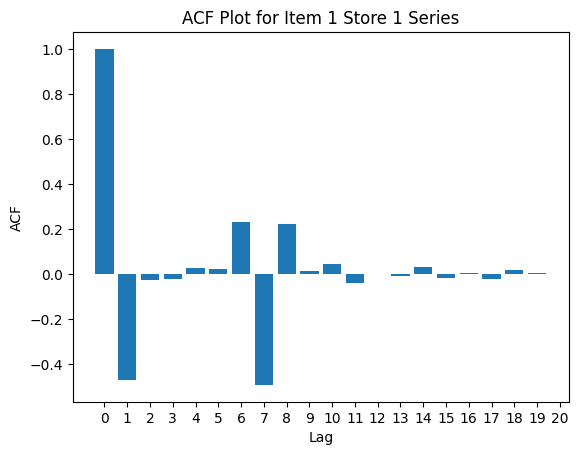

In [5]:
acf_vals = acf(series2, nlags=365)
num_lags = 20

plt.title("ACF Plot for Item 1 Store 1 Series")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.xticks(range(num_lags+1))
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.show()

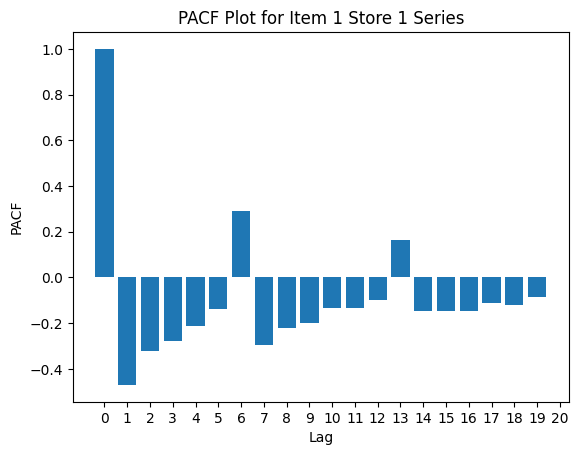

[(0, 1.0), (1, -0.4700366847774754), (2, -0.32132842743120743), (3, -0.2780692387990533), (4, -0.21211507453102238), (6, 0.29295161351962423), (7, -0.29390817450909895), (8, -0.22042475513793366), (81, -0.2540407673855978), (82, -0.24592981239721257), (84, -0.2767468287514294), (85, -0.4756955186806928), (86, -0.8446589161478837), (87, -5.812765868404559), (88, 1.2103093263075675), (89, 0.5849636979589014), (90, 0.3844356797584898), (91, 0.2380311218551783), (97, 0.2019385956800167), (162, 0.22006523725767924), (163, 0.29322487698098115), (164, 0.3915303231653288), (165, 0.6086724166643667), (166, 1.5833238780541241), (167, -2.8427121385870793), (168, -0.7586130537415481), (169, -0.4558873739993801), (170, -0.3090534873455825), (171, -0.22184824879272824), (172, -0.20251703581359354), (224, -0.21157753676007984), (225, -0.2282317053166521), (226, -0.26003767965615787), (227, -0.3494666348475549), (228, -0.5963321703384825), (229, -1.3896022047210055), (230, 3.4056995920994484), (231, 0

In [6]:
pacf_vals = pacf(series2, nlags=365)
num_lags = 20

plt.title("PACF Plot for Item 1 Store 1 Series")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.xticks(range(num_lags+1))
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.show()

print(list((i,val) for i, val in enumerate(pacf_vals) if (abs(val) > 0.2) ))

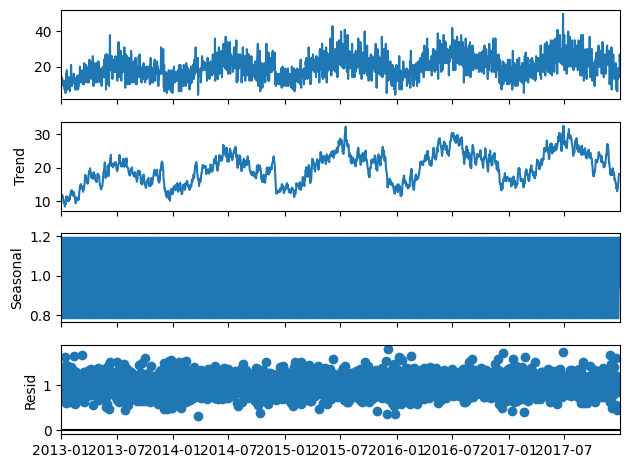

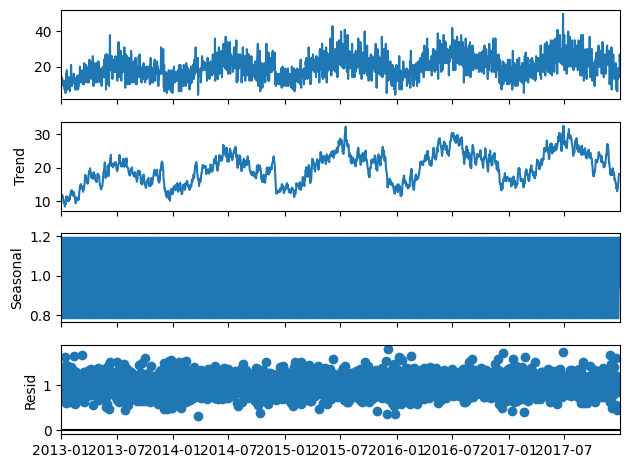

In [7]:
result = seasonal_decompose(series1, model='multiplicative')
result.plot()

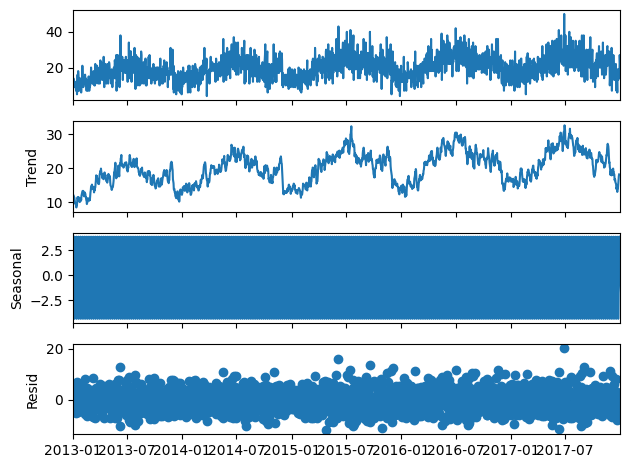

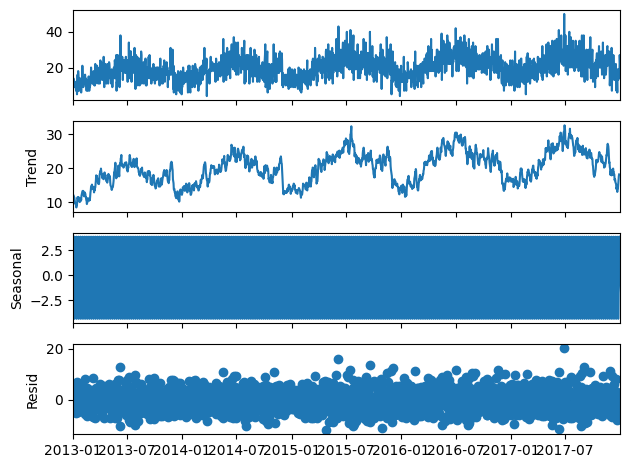

In [8]:
result2 = seasonal_decompose(series1, model='additive')
result2.plot()

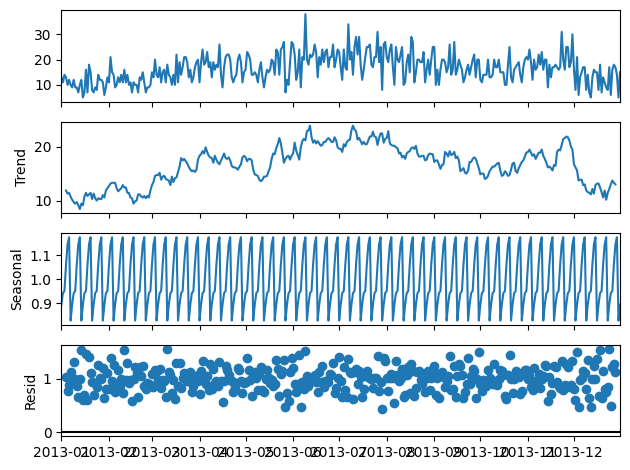

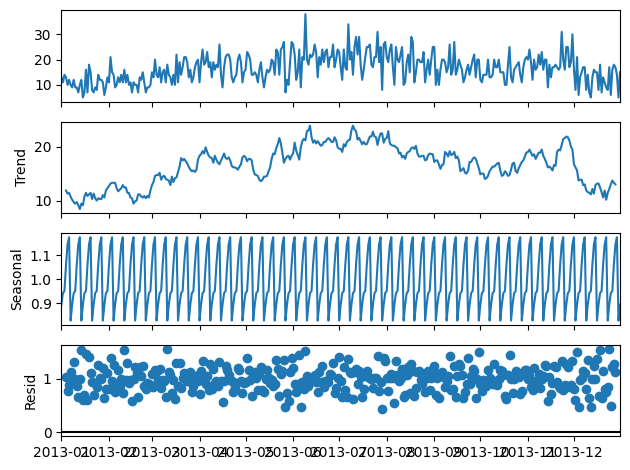

In [9]:
# Make it smaller
result3 = seasonal_decompose(series1[:365], model='multiplicative')
result3.plot()

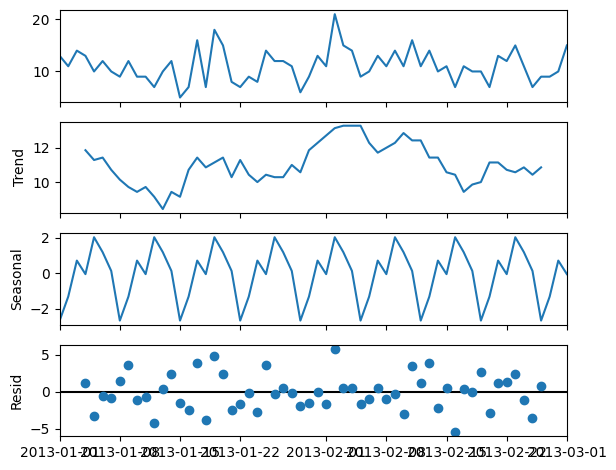

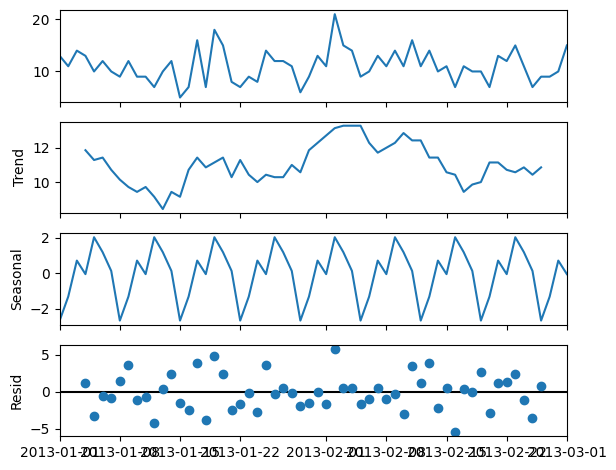

In [10]:
# Make it smaller
result4 = seasonal_decompose(series1[:60], model='additive')
result4.plot()

### Above results shows a weekly season but can't get good results for ARIMA trained with weekly seasons because expected mean (for the forecast) flatlines. ARIMA trained with yearly seasons performs well (for out-of-sample forecasting) but runs contrary to the analysis shown - moreover, it takes way longer to train.

## There may be multiple seasonality: Week and Year mainly. ARIMA can only do one season out of the box.

### After some consideration I have decided to use Fourier Transform with non-seasonal ARIMA, since seasonal arima with (freq=365) takes too long. There may be problems with overfitting since fourier approximation of the time series works too well. We also need to try a rolling training approach for ARIMA since it flatlines for large out-of-season forecast range.

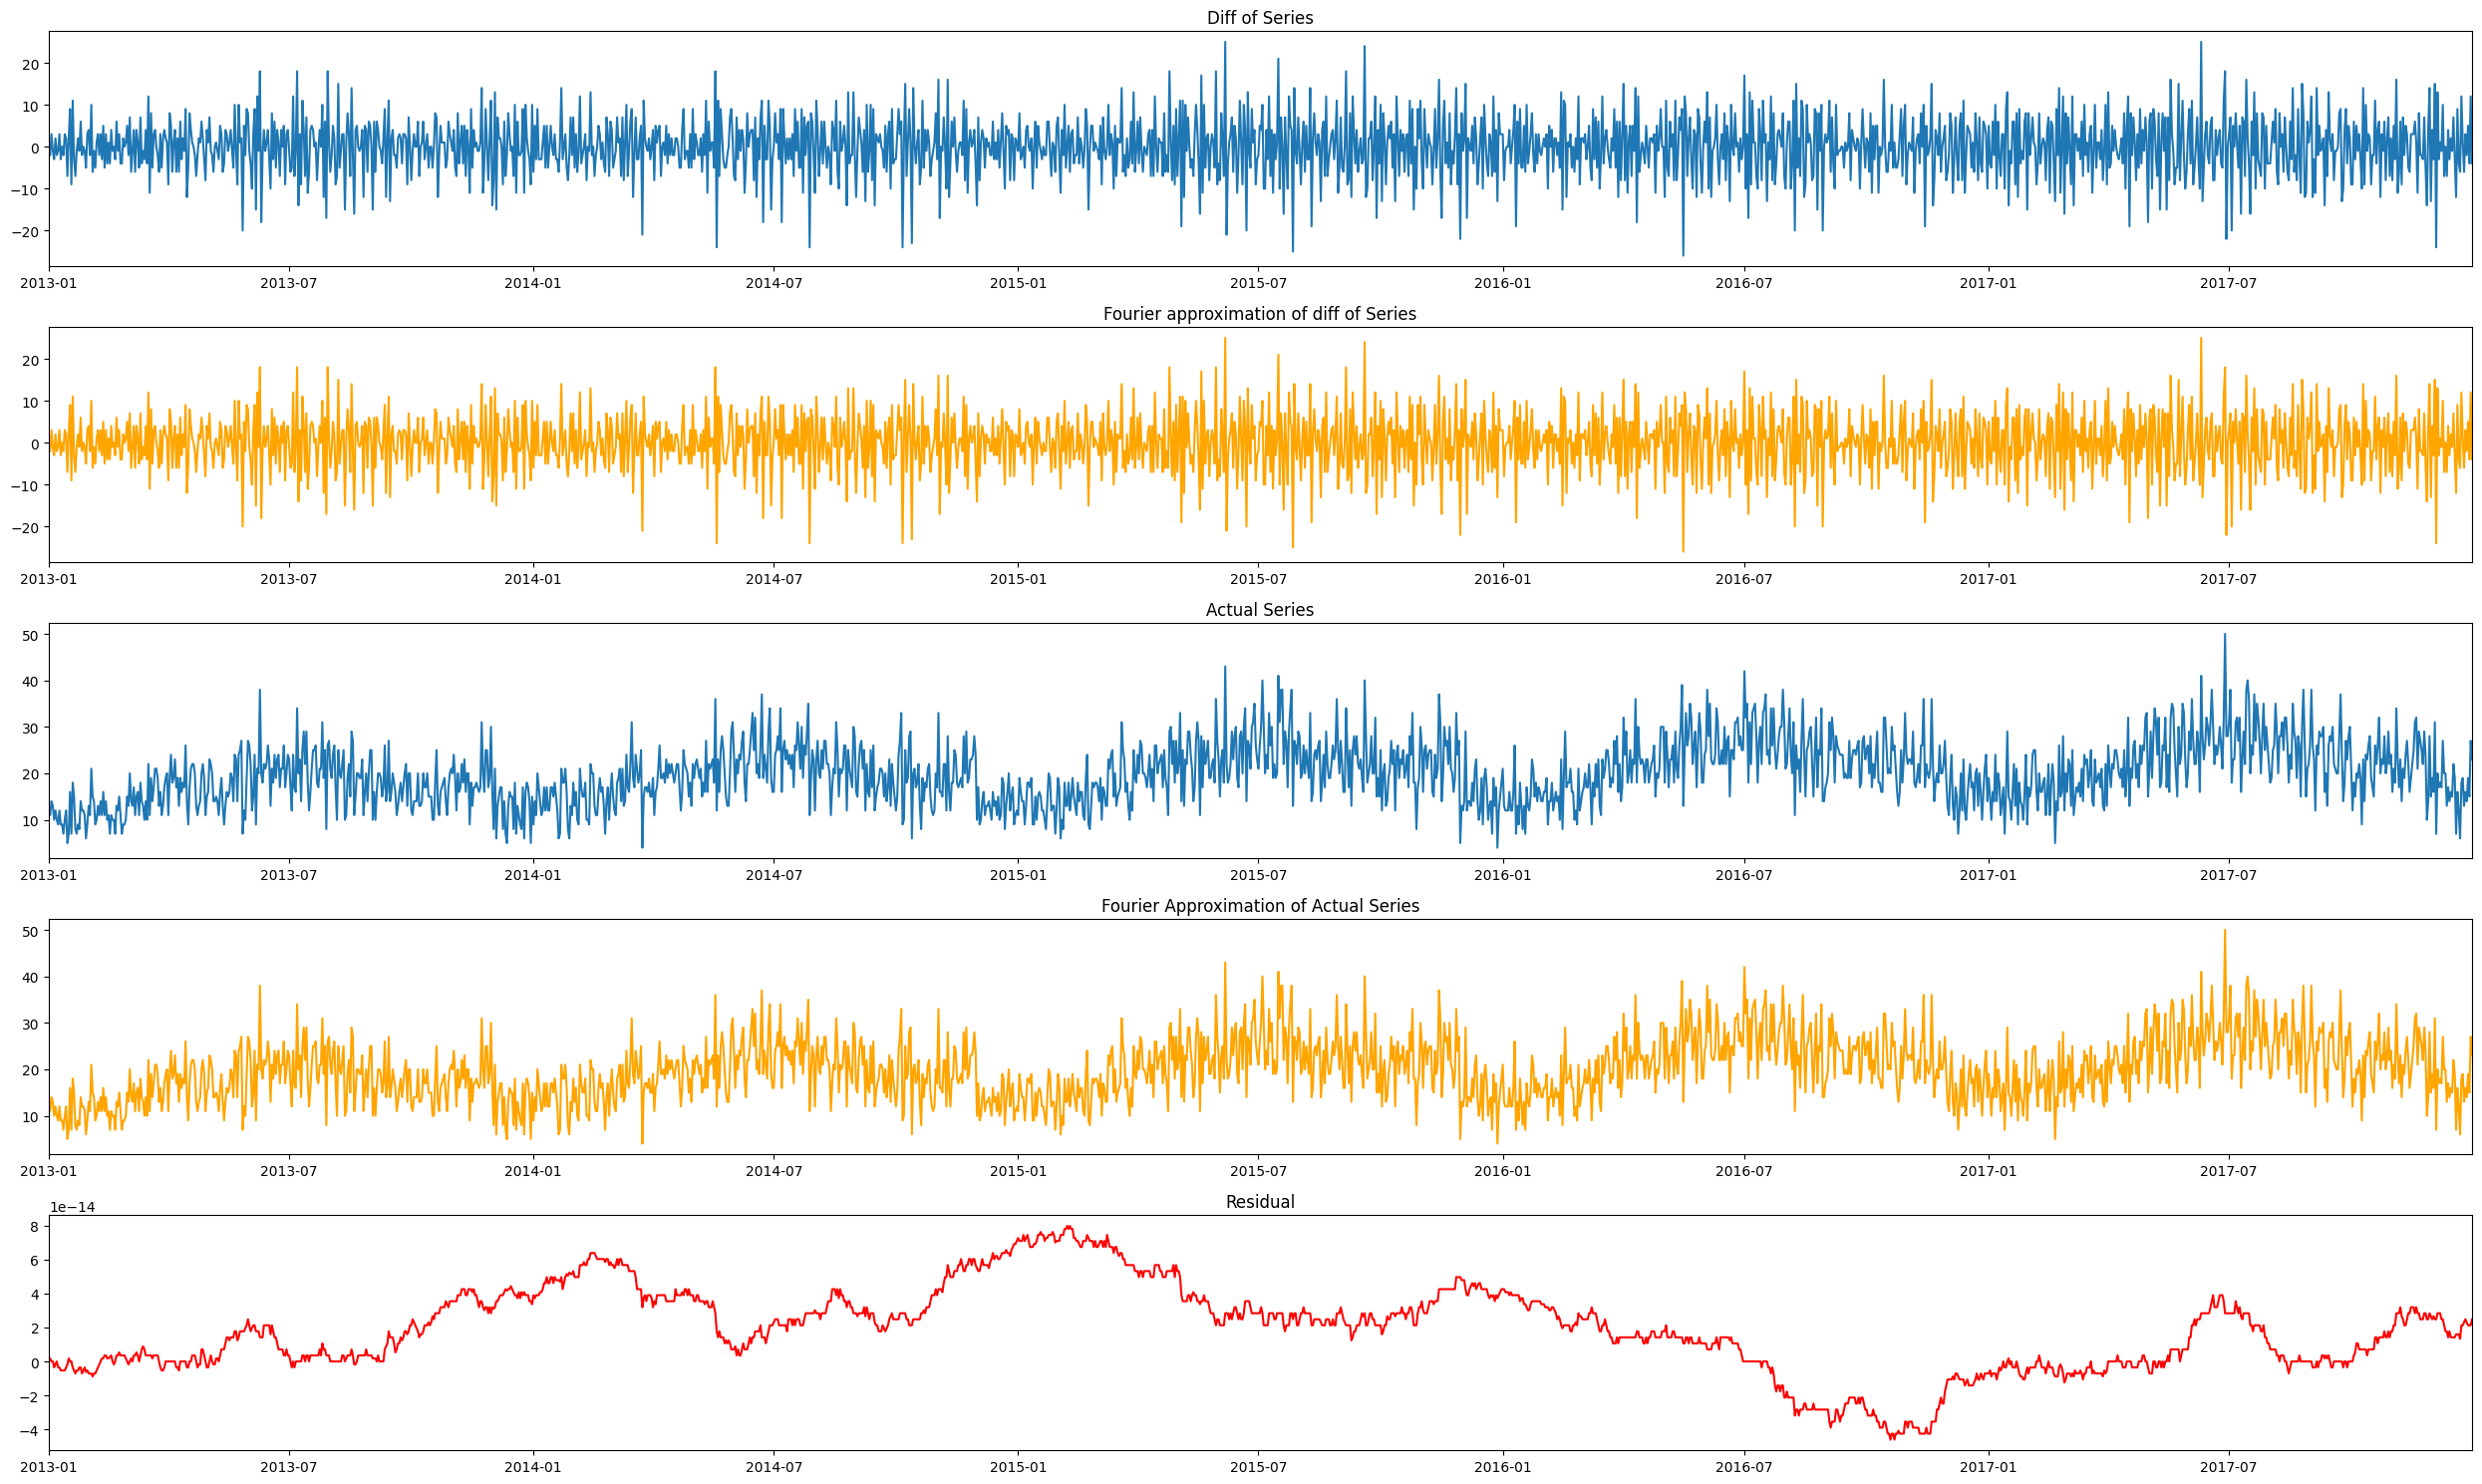

In [191]:
fig, axs = plt.subplots(5, figsize=(25,15))

forecast_range = 0

series2 = series1.diff()
f2 = np.fft.fft(series2.dropna())
res2 = np.fft.ifft(f2, n = len(f2)+forecast_range)
# Start at date index 1
res2 = pd.Series(res2.real, 
                index=pd.date_range(start=series2.index[1], periods=len(res2), freq='D'))

pred2 = pd.concat([series1[:1], res2]).cumsum()

start_date = series1.index[0]
end_date = res2.index[-1]

fourier_color = "orange"

axs[0].plot(series2)
axs[0].set_title("Diff of Series")
axs[0].set_xlim(start_date, end_date)

axs[1].plot(res2, color=fourier_color)
axs[1].set_title("Fourier approximation of diff of Series")
axs[1].set_xlim(start_date, end_date)

axs[2].plot(series1)
axs[2].set_title("Actual Series")
axs[2].set_xlim(start_date, end_date)

axs[3].plot(pred2, color=fourier_color)
axs[3].set_title("Fourier Approximation of Actual Series")
axs[3].set_xlim(start_date, end_date)

axs[4].plot(series1-pred2, color = "red")
axs[4].set_title("Residual")
axs[4].set_xlim(start_date, end_date)

plt.tight_layout()

### Although the residual result is good (random walk), it might be overfitting the data. Plus IFFT is inflexible and not meant for this usecase. Will have to recreate the time series from the fourier coefficients manually.

In [198]:
f = np.fft.fftfreq(10)
f

array([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1])

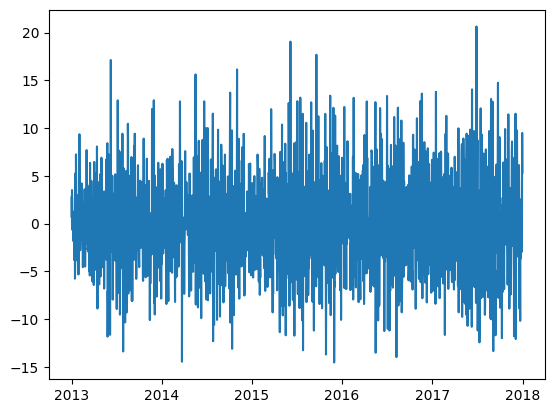

In [264]:
def fourier_extrapolation(x, n_predict, n_harm=50):
    n = x.size
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # Find linear trend in x
    x_detrended = x - p[0] * t      # Detrended x
    x_freq_domain = np.fft.fft(x_detrended)  # Detrended x in the frequency domain
    f = np.fft.fftfreq(n)              # Frequencies
    indexes = list(range(n))
    # Sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_signal = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        amplitude = np.absolute(x_freq_domain[i]) / n   # Amplitude
        phase = np.angle(x_freq_domain[i])             # Phase
        restored_signal += amplitude * np.cos(2 * np.pi * f[i] * t + phase)
        
    restored_signal = restored_signal + p[0] * t
    restored_signal = pd.Series(restored_signal, 
                               index=pd.date_range(
                                   start=x.index[0],
                                   periods=len(x) + n_predict,
                                   freq='D'
                               )
                              )

    return restored_signal

plt.plot(series1 - fourier_extrapolation(series1, 1000))

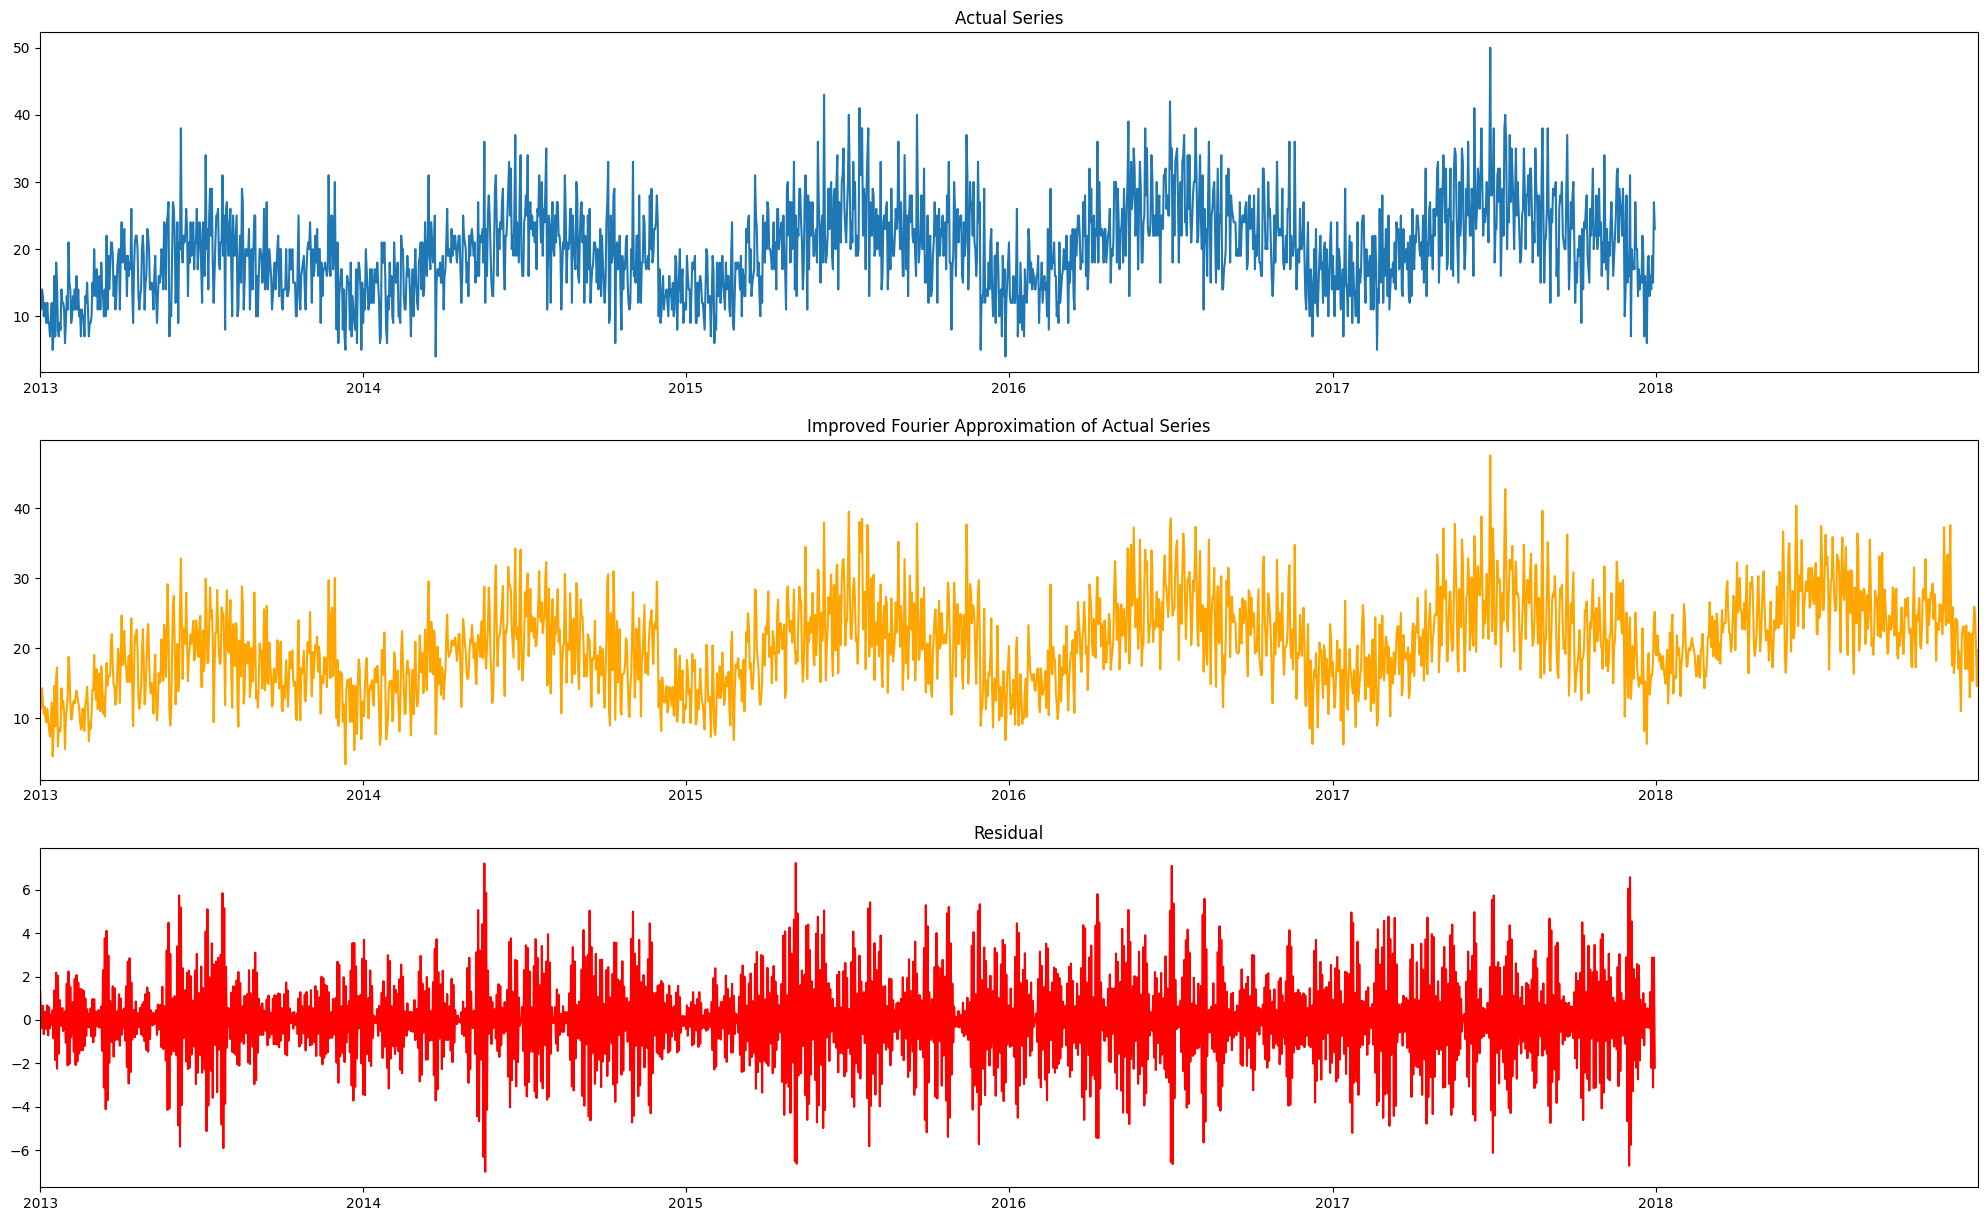

In [390]:
fig, axs = plt.subplots(3, figsize=(25,15))

forecast_range = 365

pred3 = fourier_extrapolation(series1, forecast_range, 365*2)
res3 = series1 - pred3

start_date = pred3.index[0]
end_date = pred3.index[-1]

fourier_color = "orange"

# axs[0].plot(series2)
# axs[0].set_title("Diff of Series")
# axs[0].set_xlim(start_date, end_date)

# axs[1].plot(res2, color=fourier_color)
# axs[1].set_title("Fourier approximation of diff of Series")
# axs[1].set_xlim(start_date, end_date)

axs[0].plot(series1)
axs[0].set_title("Actual Series")
axs[0].set_xlim(start_date, end_date)

axs[1].plot(pred3, color=fourier_color)
axs[1].set_title("Improved Fourier Approximation of Actual Series")
axs[1].set_xlim(start_date, end_date)

axs[2].plot(res3, color = "red")
axs[2].set_title("Residual")
axs[2].set_xlim(start_date, end_date)
# plt.text(2, 0.65, "ABC")

# plt.tight_layout()
plt.show()

In [391]:
np.sqrt(np.sum((series1-pred3)**2))

95.93556902840187

In [392]:
len(series1)

1826

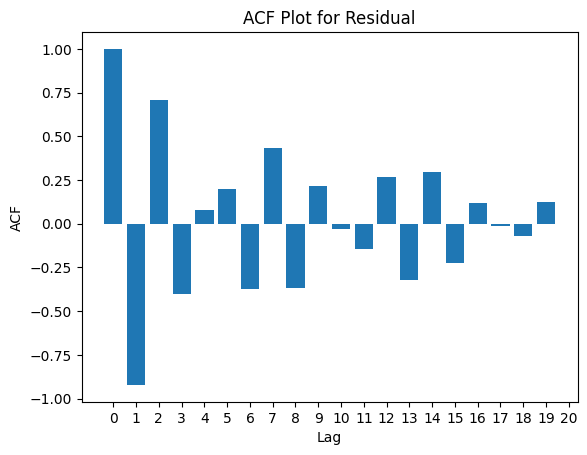

In [393]:
acf_vals = acf(res3.dropna())
num_lags = 20

plt.title("ACF Plot for Residual")
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.xticks(range(num_lags+1))
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.show()

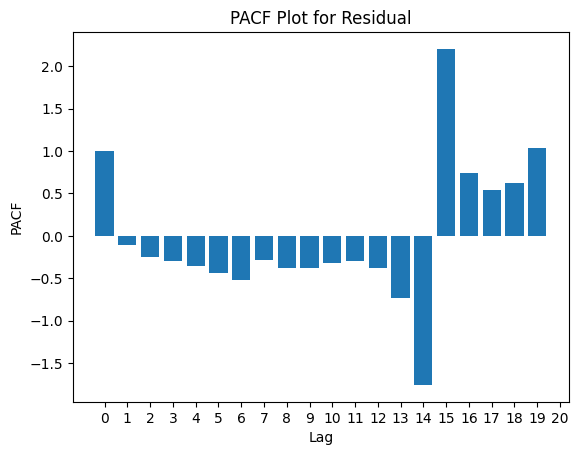

In [381]:
pacf_vals = pacf(res3.dropna())
num_lags = 20

plt.title("PACF Plot for Residual")
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.xticks(range(num_lags+1))
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.show()

/media/windows/Users/min/My_Documents/School/Year3Semester1/SC4000/Demand_Forecast/_build/pip_packages/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/media/windows/Users/min/My_Documents/School/Year3Semester1/SC4000/Demand_Forecast/_build/pip_packages/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/media/windows/Users/min/My_Documents/School/Year3Semester1/SC4000/Demand_Forecast/_build/pip_packages/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


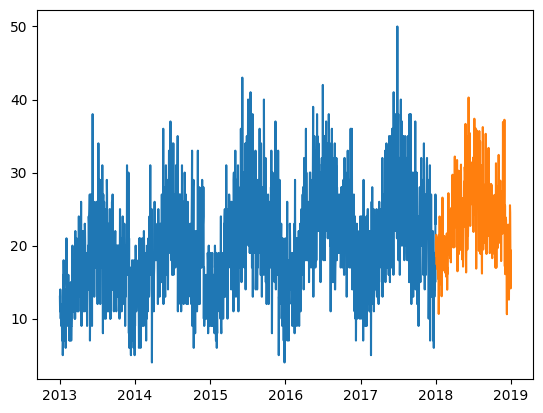

In [394]:
model = ARIMA(series1, order=(6,2,1), exog=pred3[:len(series1)]).fit()
plt.plot(series1)
plt.plot(model.forecast(forecast_range, exog=pred3[len(series1):len(series1)+forecast_range]))

In [395]:
np_pred3 = np.array(pred3).reshape(-1, 1)
model = auto_arima(series1, np_pred3[:len(series1)].reshape(-1,1))
model

/media/windows/Users/min/My_Documents/School/Year3Semester1/SC4000/Demand_Forecast/_build/pip_packages/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/media/windows/Users/min/My_Documents/School/Year3Semester1/SC4000/Demand_Forecast/_build/pip_packages/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/media/windows/Users/min/My_Documents/School/Year3Semester1/SC4000/Demand_Forecast/_build/pip_packages/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


ARIMA(order=(4, 0, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

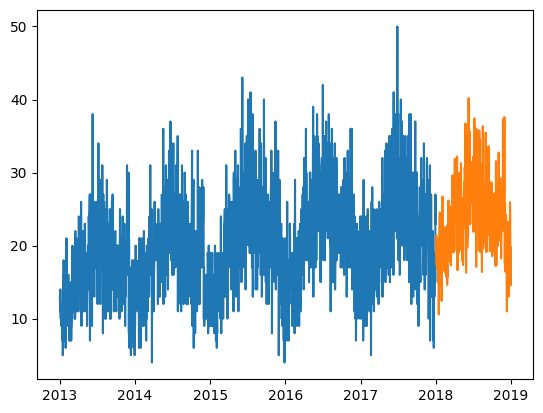

In [396]:
plt.plot(series1)
plt.plot(model.predict(forecast_range, np_pred3[len(series1):len(series1)+forecast_range]))